This tutorial is for the calibration of an Xpad_flat on the Soleil Diffabs Diffractometer.

The calibration data is a scan on the delta motor with a CeO2 calibrant.

In [1]:
%matplotlib nbagg

# first the imports
from typing import Iterator, List, NamedTuple, Text, Tuple

import os
import functools

from collections import namedtuple

import numpy
import pylab
import pyFAI

from h5py import Dataset, File

from pyFAI.gui import jupyter

# local import
from soleil import *

In [2]:
# temporary until the ruch is ON
ROOT = os.path.join("/home", "experiences", "instrumentation", "picca", "data", "99160066", "2016", "Run2")
PUBLISHED = os.path.join("/home", "experiences", "instrumentation", "picca", "data", "99160066", "published-data")

In [3]:
# save all the ref as images in order to do the calibration with
# pyFAI-calib[2].

def ExportEdf(params: Calibration):
    save_as_edf(params, PUBLISHED)

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.887700e-11m
SampleDetDist= 3.687106e-01m	PONI= 1.324293e-01, 3.383153e-02m	rot1=-0.001860  rot2= 0.088123  rot3= 0.000002 rad
DirectBeamDist= 370.148mm	Center: x=265.519, y=1269.273 pix	Tilt=5.050 deg  tiltPlanRotation= 88.794 deg
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.887700e-11m
SampleDetDist= 3.681912e-01m	PONI= 1.311321e-01, 3.376145e-02m	rot1=-0.002289  rot2= 0.142821  rot3= -0.000007 rad
DirectBeamDist= 371.979mm	Center: x=266.185, y=1415.984 pix	Tilt=8.184 deg  tiltPlanRotation= 89.088 deg
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.887700e-11m
SampleDetDist= 3.664426e-01m	PONI= 1.354038e-01, 3.623778e-02m	rot1=0.003809  rot2= 0.182456  rot3= -0.000000 rad
DirectBeamDist= 372.631mm	Center: x=268.015, y=1561.660 pix	Tilt=10.456 deg  tiltPlanRotation= 91.183 deg
Filled refi

<IPython.core.display.Javascript object>


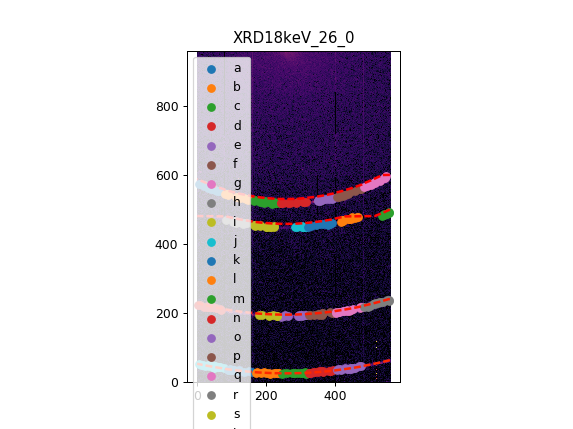

<IPython.core.display.Javascript object>


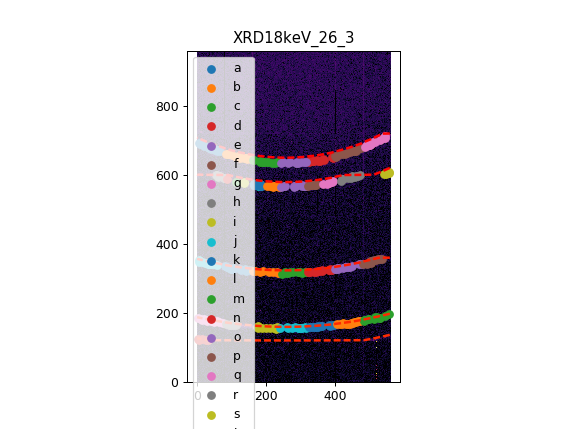

<IPython.core.display.Javascript object>


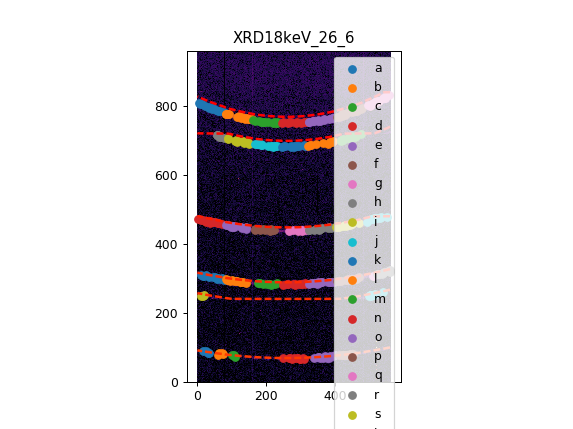

Cost function before refinement: 1.46449751925
     fun: 1.464497510610393
     jac: array([ -1.46658987e-01,  -5.04313111e-02,  -3.36056948e-03,
         4.33608890e-04,  -1.24866045e+00,   4.47034836e-08,
         0.00000000e+00,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  2.58705917e-01,   1.32825375e-01,   3.53283259e-02,
         1.07006113e-03,   1.00000000e+00,   2.10756891e-01,
         7.19961198e-07])
Cost function after refinement: 1.46449751061
GonioParam(dist=0.258705917299, poni1=0.13282537472100001, poni2=0.035328325866600001, rot1=0.0010700611337299999, rot2_scale=1.0, rot2_offset=0.21075689052542637, rot3=7.1996119809799997e-07)
maxdelta on: rot2_offset (5) 0.2108502356960398 --> 0.210756890525


XRD18keV_26_1
ControlPoints instance containing 2 group of point:
CeO2 Calibrant with 41 reflections at wavelength 6.8877e-11
Containing 2 groups of points:
#ak ring 0: 

<IPython.core.display.Javascript object>


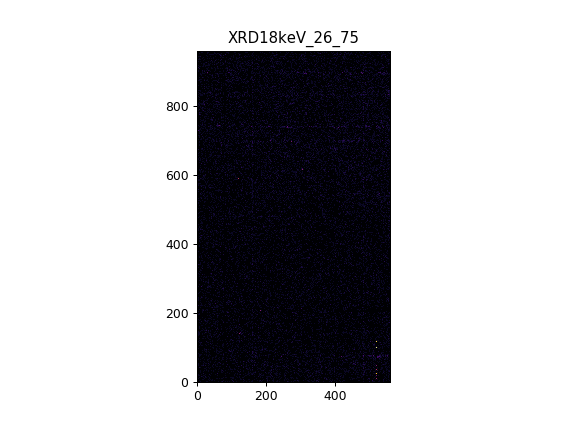

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [4]:
# do the calibration
json = os.path.join(PUBLISHED, "calibration", "calibration.json")

distance = Length(0.258705917299)
poni1 = Length(0.132825374721)
poni2 = Length(0.0353283258666)
rot1 = Angle(0.00107006113373)
rot2_scale = 1.0
rot2_offset = Angle(0.21085023569603981)
rot3 = Angle(7.19961198098e-07)

params = Calibration(os.path.join(PUBLISHED, "calibration", "XRD18keV_26.nxs"),
                     DatasetPathWithAttribute("interpretation", b"image"),
                     DatasetPathContains("scan_data/actuator_1_1"),
                     [0, 3, 6],
                     Calibrant("CeO2"),
                     Detector("Xpad_flat"),
                     Wavelength(6.8877e-11),
                     CalibrationParameters(Parameter[Length]("dist", distance, (distance, distance)),
                                           Parameter[Length]("poni1", poni1, (poni1, poni1)),
                                           Parameter[Length]("poni2", poni2, (poni2, poni2)),
                                           Parameter[Angle]("rot1", rot1, (rot1, rot1)),
                                           Parameter[Angle]("rot2_scale", rot2_scale, (rot2_scale, rot2_scale)),
                                           Parameter[Angle]("rot2_offset", rot2_offset, (rot2_offset-0.5, rot2_offset+0.5)),
                                           Parameter[Angle]("rot3", rot3, (rot3, rot3))
                                          )
                    )

calibration(json, params)

In [5]:
import pylab
pylab.show()